# Nonlinear Sensor Fusion

In [ ]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate(); 
using RxInfer, Random, LinearAlgebra, Distributions, Plots, StatsPlots, Flux, DataFrames, DelimitedFiles, StableRNGs

In a secret ongoing mission to Mars, NASA has deployed its custom lunar roving vehicle, called WALL-E, to explore the area and to discover hidden minerals. During one of the solar storm, WALL-E's GPS unit got damaged, preventing it from accurately locating itself. The engineers at NASA were devastated as they developed the project over the past couple of years and spend most of their funding on it. Without being able to locate WALL-E, they were unable to complete their mission.

A smart group of engineers came up with a solution to locate WALL-E. They decided to repurpose 3 nearby satelites as beacons for WALL-E, allowing it to detect its relative location to these beacons. However, these satelites were old and therefore WALL-E was only able to obtain noisy estimates of its distance to these beacons. These distances were communicated back to earth, where the engineers tried to figure our WALL-E's location. Luckily they knew the locations of these satelites and together with the noisy estimates of the distance to WALL-E they can infer the exact location of the moving WALL-E.

To illustrate these noisy measurements, the engineers decided to plot them:

In [2]:
# fetch measurements
beacon_locations = readdlm("data/sensor_fusion/beacons.txt")
distances = readdlm("data/sensor_fusion/distances.txt")
position = readdlm("data/sensor_fusion/position.txt")
nr_observations = size(distances, 1);

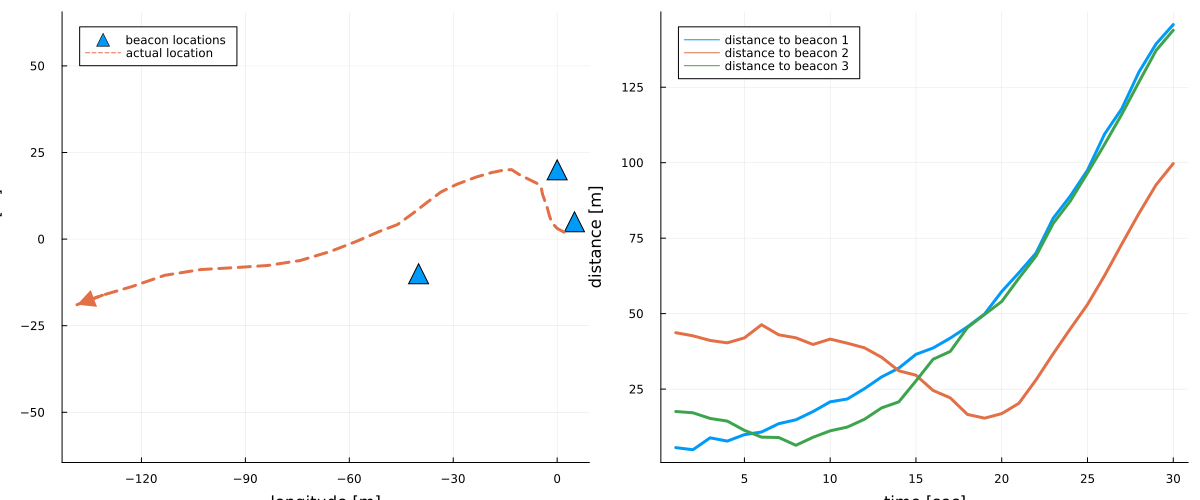

In [3]:
# plot beacon and actual location of WALL-E
p1 = scatter(beacon_locations[:,1], beacon_locations[:,2], markershape=:utriangle, markersize=10, legend=:topleft, label="beacon locations")
plot!(position[1,:], position[2,:], label="actual location", linewidth=3, linestyle=:dash, arrow=(:closed, 2.0), aspect_ratio=1.0)
xlabel!("longitude [m]"), ylabel!("latitude [m]")

# plot noisy distance measurements
p2 = plot(distances, legend=:topleft, linewidth=3, label=["distance to beacon 1" "distance to beacon 2" "distance to beacon 3"])
xlabel!("time [sec]"), ylabel!("distance [m]")

plot(p1, p2, size=(1200, 500))

In order to track the location of WALL-E based on the noisy distance measurements to the beacon, the engineers developed a probabilistic model for the movements for WALL-E and the distance measurements that followed from this. The engineers assumed that the position of WALL-E at time $t$, denoted by $z_t$, follows a 2-dimensional normal random walk:

$$\begin{aligned}
 & p(z_t \mid z_{t - 1}) = \mathcal{N}(z_t \mid z_{t-1},~\mathrm{I}_{2}),\\
\end{aligned}$$
where $\mathrm{I}_2$ denotes the 2-dimensional identity matrix. From the current position of WALL-E, we specify our noisy distance measurements $y_t$ as a noisy set of the distances between WALL-E and the beacons, specified by $s_i$:

$$\begin{aligned}
 & p(y_t \mid z_t)  = \mathcal{N} \left (y_t \left \vert \begin{bmatrix} \| z_{t} - s_{1}\| \\ \|z_{t} - s_{2}\| \\ \|z_{t} - s_{3}\|\end{bmatrix}\!,~\mathrm{I}_{3}\! \right . \right)\!.
\end{aligned}$$

The engineers are smart enough to automate the probabilistic inference procedure using `RxInfer.jl`. They specify the probabilistic model as:

In [4]:
# function to compute distance to beacons
function compute_distances(z)    
    distance1 = norm(z - beacon_locations[1,:])
    distance2 = norm(z - beacon_locations[2,:])
    distance3 = norm(z - beacon_locations[3,:])
    distances = [distance1, distance2, distance3]
end;

In [5]:
@model function random_walk_model(nr_observations)
    
    # specify covariance matrices
    W = diageye(2)
    R = diageye(3)

    # allocate locations and observations
    z = randomvar(nr_observations)
    y = datavar(Vector{Float64}, nr_observations)

    # specify initial estimates of the location
    z[1] ~ MvNormalMeanCovariance(zeros(2), diageye(2)) 
    y[1] ~ MvNormalMeanCovariance(compute_distances(z[1]), diageye(3))

    # loop over time steps
    for t in 2:nr_observations

        # specify random walk state transition model
        z[t] ~ MvNormalMeanPrecision(z[t-1], W)

        # specify non-linear distance observations model
        y[t] ~ MvNormalMeanPrecision(compute_distances(z[t]), R)
        
    end

end;

Because of the non-linearity, exact probabilistic inference is intractable. Therefore we resort to Conjugate-NonConjugate Variational Inference (CVI) following the paper [Probabilistic programming with stochastic variational message passing](https://reader.elsevier.com/reader/sd/pii/S0888613X22000950?token=EFB22E01793BD0BF73EECC9702C315644969403BD44B13FA850E9F66C8A49E88C0D5C68A9AD03301C609DA443DB33F80&originRegion=eu-west-1&originCreation=20221027115856). This requires setting the `@meta` macro in `RxInfer.jl`.

In [6]:
@meta function random_walk_model_meta(nr_samples, nr_iterations, rng)
    compute_distances(z) -> CVIApproximation(rng, nr_samples, nr_iterations, Descent(0.1))
end;

Because the engineers are using `RxInfer.jl`, they can automate the inference procedure. They run the model once with a limited numbers of samples and iterations, for speed, and once for accuracy.

In [7]:
results_fast = inference(
    model = random_walk_model(nr_observations),
    meta = random_walk_model_meta(1, 3, StableRNG(42)),
    data = (y = [distances[t,:] for t in 1:nr_observations],),
    iterations = 100,
    free_energy = false,
    returnvars = (z = KeepLast(),),
    initmessages = (z = MvNormalMeanPrecision(zeros(2), 0.01 * diageye(2)),),
);

In [8]:
results_accuracy = inference(
    model = random_walk_model(nr_observations),
    meta = random_walk_model_meta(1000, 100, StableRNG(42)),
    data = (y = [distances[t,:] for t in 1:nr_observations],),
    iterations = 100,
    free_energy = false,
    returnvars = (z = KeepLast(),),
    initmessages = (z = MvNormalMeanPrecision(zeros(2), 0.01 * diageye(2)),),
);

After running this fast inference procedure, the engineers plot the results and evaluate the performance:

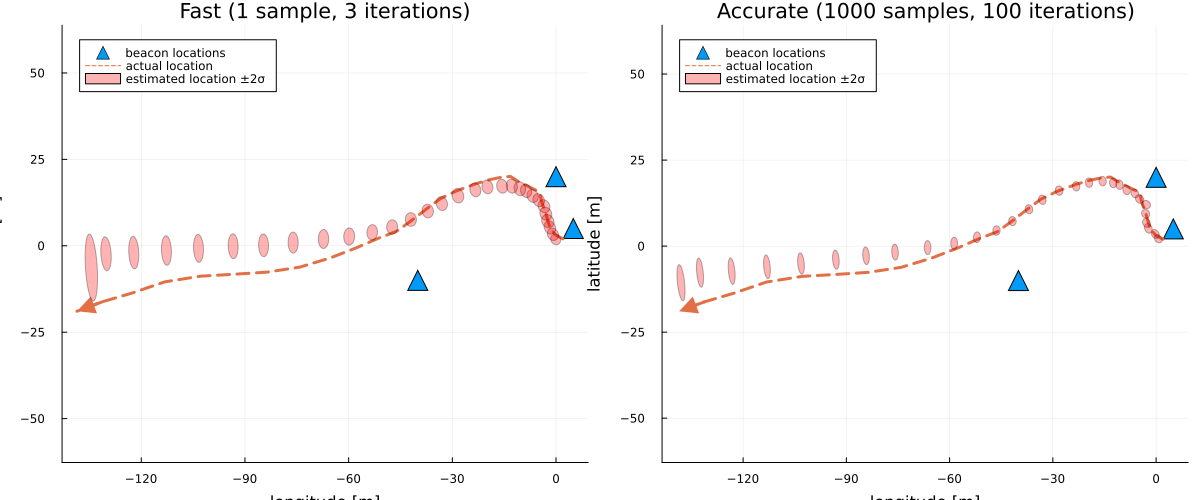

In [9]:
# plot beacon and actual and estimated location of WALL-E (fast inference)
p1 = scatter(beacon_locations[:,1], beacon_locations[:,2], markershape=:utriangle, markersize=10, legend=:topleft, label="beacon locations")
plot!(position[1,:], position[2,:], label="actual location", linewidth=3, linestyle=:dash, arrow=(:closed, 2.0), aspect_ratio=1.0)
map(posterior -> covellipse!(mean(posterior), cov(posterior), color="red", label="", n_std=2), results_fast.posteriors[:z])
xlabel!("longitude [m]"), ylabel!("latitude [m]"), title!("Fast (1 sample, 3 iterations)"); p1.series_list[end][:label] = "estimated location ±2σ"

# plot beacon and actual and estimated location of WALL-E (accurate inference)
p2 = scatter(beacon_locations[:,1], beacon_locations[:,2], markershape=:utriangle, markersize=10, legend=:topleft, label="beacon locations")
plot!(position[1,:], position[2,:], label="actual location", linewidth=3, linestyle=:dash, arrow=(:closed, 2.0), aspect_ratio=1.0)
map(posterior -> covellipse!(mean(posterior), cov(posterior), color="red", label="", n_std=2), results_accuracy.posteriors[:z])
xlabel!("longitude [m]"), ylabel!("latitude [m]"), title!("Accurate (1000 samples, 100 iterations)"); p2.series_list[end][:label] = "estimated location ±2σ"

plot(p1, p2, size=(1200, 500))

The engineers were very happy with the solution, as it meant that the Mars mission could continue. However, they noted that the estimates began to deviate after WALL-E moved further away from the beacons. They deemed this was likely due to the noise in the distance measurements. Therefore, the engineers decided to adapt the model, such that they would also infer the process and observation noise precision matrices, $Q$ and $R$ respectively. They did this by adding Wishart priors to those matrices:

$$\begin{aligned}
 & p(Q) = \mathcal{W}(Q \mid 3, \mathrm{I}_2), \\
 & p(R) = \mathcal{W}(R \mid 4, \mathrm{I}_3), \\
 & p(z_t \mid z_{t - 1}, Q) = \mathcal{N}(z_t \mid z_{t-1}, Q^{-1}),\\
 & p(y_t \mid z_t, R)  = \mathcal{N} \left (y_t \left \vert \begin{bmatrix} \| z_{t} - s_{1}\| \\ \|z_{t} - s_{2}\| \\ \|z_{t} - s_{3}\|\end{bmatrix}\!,~R^{-1}\! \right . \right)\!.
\end{aligned}$$

In [10]:
@model function random_walk_model_wishart(nr_observations)

    # allocate locations and observations
    z = randomvar(nr_observations)
    y = datavar(Vector{Float64}, nr_observations)

    # set priors on precision matrices
    Q ~ Wishart(3, diageye(2))
    R ~ Wishart(4, diageye(3))

    # specify initial estimates of the location
    z[1] ~ MvNormalMeanCovariance(zeros(2), diageye(2)) 
    y[1] ~ MvNormalMeanCovariance(compute_distances(z[1]), diageye(3))

    # loop over time steps
    for t in 2:nr_observations

        # specify random walk state transition model
        z[t] ~ MvNormalMeanPrecision(z[t-1], Q)

        # specify non-linear distance observations model
        y[t] ~ MvNormalMeanPrecision(compute_distances(z[t]), R)
        
    end

end;

In [11]:
meta = @meta begin 
    compute_distances(z) -> CVIApproximation(StableRNG(42), 2000, 100, Descent(0.01))
end;

Because of the added complexity with the Wishart distributions, the engineers simplify the problem by employing a structured mean-field factorization:

In [12]:
constraints = @constraints begin
    q(z, Q, R) = q(z)q(Q)q(R)
end;

The engineers run the inference procedure again and decide to track the inference performance using the Bethe free energy.

In [13]:
results_wishart = inference(
    model = random_walk_model_wishart(nr_observations),
    data = (y = [distances[t,:] for t in 1:nr_observations],),
    iterations = 100,
    free_energy = true,
    returnvars = (z = KeepLast(),),
    constraints = constraints,
    meta = meta,
    initmessages = (z = MvNormalMeanPrecision(zeros(2), 0.01 * diageye(2)),),
    initmarginals = (R = Wishart(4, diageye(3)), Q = Wishart(3, diageye(2)))
);

They plot the new estimates and the performance over time, and luckily WALL-E is found!

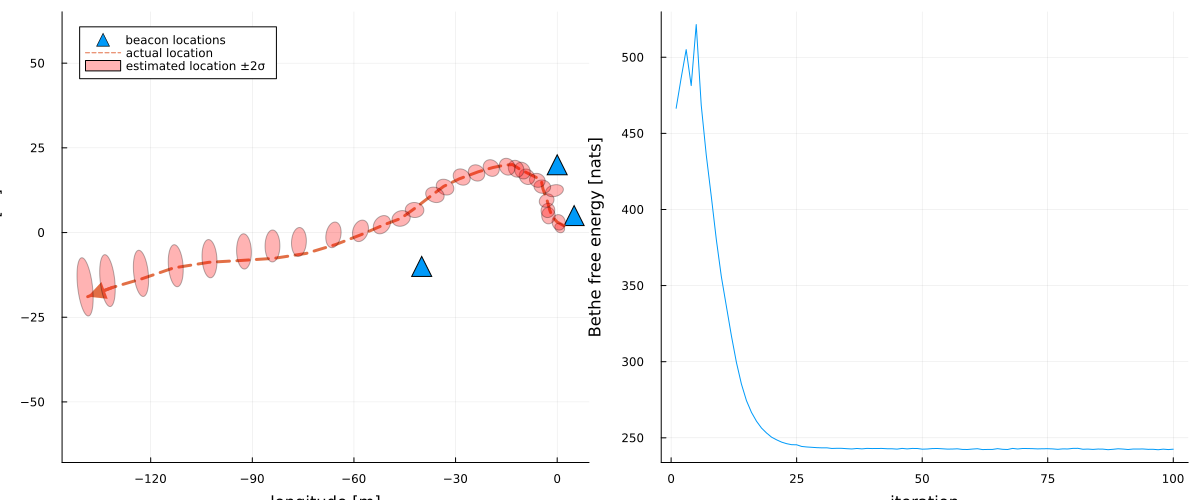

In [14]:
# plot beacon and actual and estimated location of WALL-E (fast inference)
p1 = scatter(beacon_locations[:,1], beacon_locations[:,2], markershape=:utriangle, markersize=10, legend=:topleft, label="beacon locations")
plot!(position[1,:], position[2,:], label="actual location", linewidth=3, linestyle=:dash, arrow=(:closed, 2.0), aspect_ratio=1.0)
map(posterior -> covellipse!(mean(posterior), cov(posterior), color="red", label="", n_std=2), results_wishart.posteriors[:z])
xlabel!("longitude [m]"), ylabel!("latitude [m]"); p1.series_list[end][:label] = "estimated location ±2σ"

# plot bethe free energy performance
p2 = plot(results_wishart.free_energy, label = "")
xlabel!("iteration"), ylabel!("Bethe free energy [nats]")

plot(p1, p2, size=(1200, 500))